In [122]:

######################### This version is meant to be a clone or Dr.Orlandi's version. Using his psych curve etc. goal is to clone behaviour. Will Implement objects.
######################### And then modify from there 



################################################GONNA SWITCH FROM -1,0,1 to 0,1,2
#gonna work in radians


In [123]:
#imports
import numpy as np
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import random


In [124]:
################### GLOBAL VARIABLES

NUMANGLES = 42 #how many orientations each side can take
MAXPROB = .9


ANGLEMAX = np.pi/2
ANGLEMIN = -np.pi/2

MAX_EPOCHS = 100 # Total epochs
BATCH_SIZE = 660 # Trials per batch

NOCHOICEVAL = 1
LEFTCHOICEVAL = 0  #Value output when choosing left bar
RIGHTCHOICEVAL = 2 #Value output when choosing right bar

UNITS = 256 # Number of neurons in the dense layer
OUTPUT_SIZE = 3 # Number of output states
INPUT_DIMENSION = 3 #dimension of input. it will be 3 when there is attention included into model. 

STIMULUSDURATION = 4 #length of the stimulus (seconds)
PRESTIMULUSDURATION = 1 #length of the pre stimulus (seconds)

ONECHOICE = False #wheteher maskes one choice and sticks or changes mind


FRAMERATE = 10 #(hz)

TOTALFRAMES = int(FRAMERATE*(STIMULUSDURATION + PRESTIMULUSDURATION)) #total number of frames

LASTFRAME = TOTALFRAMES - 1 #Index of last frame

ATTENTION_LEVELS = [0,1]  # Binary attention, currently -> low (0) or high (1)

PRESTIMULUSFRAME = int(PRESTIMULUSDURATION * FRAMERATE) - 1
STIMULUS_FRAME = PRESTIMULUSFRAME + 1

#################################################

In [125]:
class timeSeries:
    '''Class whose objects are times series of an instance'''
    #Initialize it with an empty time series
    def __init__(self, series):
        self.tSeries = series
    

In [126]:
class anglePair:
    def __init__(self, angle1, angle2):
        self.angle1 = angle1
        self.angle2 = angle2

In [127]:
class decisionMaker:
    def __init__(self, attention):
        self.attention = attention

    def difficulty(self, angles):
        angle1 = angles[0]
        angle2 = angles[1]
        sameSign = True
        difference = abs( abs(angle1) - abs(angle2) )
        if abs(angle1 + angle2) < abs(angle1)+abs(angle2): #if they are opposite sign
            sameSign = False    

        beta = 0.06 #slope parameter for steepness of difficulty curve (a function of angle separation)

        #####  HOW ATTENTION CHANGES THINGS. It affects prob at lowest difficulty
        if self.attention == 0:
            alpha = .28 #Alpha is the value of difficulty at angle difference of max
          
        elif self.attention == 1:
            alpha = 0.0001 
            

        offset = np.arctanh( 2*alpha - 1 )/beta #shift the graph so at x = 0 f(x) is alpha
        f = .4 #Parameter for the slope of the mapping of difference to input to the difficulty function
        if not sameSign: #the angles are not the same side so add a bias to the difficulty
            y = 0.6  #parameter affecting how much f is changed when the angles are on same side or not
            f = f - y*f
        x = 1/(f*difference) #scale it so small differences are large value and big differences are small
        dif = 1/2 * ( np.tanh( beta * (x + offset) ) + 1 )
        return dif

    def correctChoice(self, angles):
        '''input 2 angles return the smaller angle corresponding to more vertical orientation
        Angle 1 is left angle 2 is right. Returns -1 for Left 1 for right
        if they are equal error is thrown because currently only training on non equal angles
        '''
        global LEFTCHOICEVAL, RIGHTCHOICEVAL
        angle1 = angles[0]
        angle2 = angles[1]
        if angle1 < angle2:
            return LEFTCHOICEVAL        #The left bar is oriented more vertically
        elif angle2 < angle1:
            return RIGHTCHOICEVAL        #The right bar is oriented more vertically
        else:
            return "Error. Not expecting equal angles" #throw error if angles are equal

    def trainedChoice(self, angles):
        '''Input two angles returns the choice the mouse makes'''
        global MAXPROB, LEFTCHOICEVAL, RIGHTCHOICEVAL
        pCorrect = self.probablilityCorrect(self.difficulty(angles))
        if pCorrect > MAXPROB:
            pCorrect = MAXPROB
        cor = self.correctChoice(angles)
        n = np.random.random()
        if n <= pCorrect: #if they are certain
            return cor
        else:
            #if not certain then it is a guess
            g = np.random.rand()
            if g < .5:
                return cor
            else:
                if cor == RIGHTCHOICEVAL:
                    return LEFTCHOICEVAL
                else:
                    return RIGHTCHOICEVAL
            
    def probablilityCorrect(self, difficulty):
        p = -1*difficulty + 1
        return p
    


In [128]:
class timeSeriesCreationMachine:
    '''This class has objects that are machines to create time series. it will have configuration options and a method that spits out time series'''

    def createInputTimeSeries(self, anglePairs, attention): 
        inputTimeSeries = timeSeries(np.zeros((TOTALFRAMES, INPUT_DIMENSION)).astype(np.float32)) #stores the trials time series'
        for frame in range(TOTALFRAMES): 
            if frame <= PRESTIMULUSFRAME: #start with [0 , 0] when no stimulus present
                inputTimeSeries.tSeries[frame][0] = 0
                inputTimeSeries.tSeries[frame][1] = 0
            else:
                #use the angles corresponding to stimulus
                inputTimeSeries.tSeries[frame][0] = anglePairs[0]
                inputTimeSeries.tSeries[frame][1] = anglePairs[1]

            #Specify the level of attention    
            inputTimeSeries.tSeries[frame][2] = attention
        return inputTimeSeries
                    
    def createOutputTimeSeries(self, inputTimeSeries, attention, oneChoice):
        #numberTrials = len(inputTimeSeries.tSeries) + 1
        outputTimeSeries = timeSeries(np.full((TOTALFRAMES), np.nan)) #stores the response time series
        firstTrainedChoice = np.nan

        decisionAgent = decisionMaker(attention)

        for frame in range(TOTALFRAMES): 
            if frame < PRESTIMULUSFRAME: 
                outputTimeSeries.tSeries[frame] = np.nan
            elif frame == PRESTIMULUSFRAME:
                outputTimeSeries.tSeries[frame] = NOCHOICEVAL
            elif frame == STIMULUS_FRAME:
                firstTrainedChoice = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame])
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
            elif oneChoice == True:#when One choice is True one choice is made when stim is shown and that choice remains. when False It makes a decision each frame.
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
            else:
                #use the angles corresponding to stimulus builds a distrobution
                outputTimeSeries.tSeries[frame] = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame]) ###ONE CONSTANT CHOICE OR CHOICE CHANGES
        return outputTimeSeries                                                                                                          



In [129]:
class ensembleCreator:
    '''uses the timeSeriesCreator class to create an ensemble of iteration time series'''
    #Generate training data
    def generateEnsemble(self, attention):
        inputList = np.array([]) #list of all trials input time series
        outputList = np.array([])#list of all trials outpu time series
        angleList = np.linspace(ANGLEMAX, ANGLEMIN, NUMANGLES)
        #list that holds the pairs [left angle, right angle]
        anglePairs = np.array([])
        #generate all pairs of angles
        for i in angleList:
            for j in angleList:      #round to deal with floating point error
                decimals = 1
                if (round(i,decimals) != round(j,decimals)) & (-round(i,decimals) != round(j,decimals)): #we dont want any pairs that have equal verticallity (same abs(angle))
                    #add noise to the angles
                    noiseScale = 10 #scales how noise the angles are
                    i += np.random.randn()/noiseScale
                    j += np.random.randn()/noiseScale
                    anglePairs = np.append(anglePairs,[i,j])
        
        anglePairs = anglePairs.reshape(-1,2)
        
        np.random.shuffle(anglePairs)

        numberTrials = len(anglePairs)

        timeSeriesCreator = timeSeriesCreationMachine()


        for trial in range(numberTrials):
            inputTimeSer = timeSeriesCreator.createInputTimeSeries(anglePairs[trial], attention) #input time series
            outputTimeSer = timeSeriesCreator.createOutputTimeSeries(inputTimeSer, attention ,ONECHOICE) # output time series
            inputList = np.append(inputList, inputTimeSer.tSeries)
            outputList = np.append(outputList, outputTimeSer.tSeries)

        inputList = inputList.reshape(numberTrials,TOTALFRAMES, INPUT_DIMENSION)    
        
        outputList = outputList.reshape(numberTrials, TOTALFRAMES)
       
        return inputList, outputList


    def generateEnsembles(self, attentionList):
        
        first = True
        for i in attentionList:
            trialsData, responseData = self.generateEnsemble(i)
            if first:
                allTrials = trialsData
                allResponses = responseData
                first = False
            else:
                allTrials = np.concatenate((allTrials, trialsData), axis = 0)
                allResponses = np.concatenate((allResponses, responseData), axis = 0)

            
        return allTrials, allResponses





In [130]:
class netModel:
    def _custom_loss(self, y_actual,y_pred): 
        '''calculates the loss using the frame immediately before stimulus and last frame of time series
        The frame before stim is to set p left and p right = 0'''
        l1 = kb.sparse_categorical_crossentropy(y_actual[:, PRESTIMULUSFRAME], y_pred[:, PRESTIMULUSFRAME])
        l2 = kb.sparse_categorical_crossentropy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
        custom_loss = l1 + l2
        return custom_loss

    def _custom_cat(self, y_actual,y_pred):
        '''Checks the accuracy of the final predicted output and compares it to the desired output'''
        l2 = tf.keras.metrics.sparse_categorical_accuracy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
        custom_cat = l2
        return custom_cat
    
    def genTestOutput(self):
        ensembleGen = ensembleCreator()

        trialsData, responseData = ensembleGen.generateEnsembles(ATTENTION_LEVELS)

        xTrain, xTest, yTrain, yTest = sk.train_test_split(
                                                            trialsData, 
                                                            responseData, 
                                                            test_size=0.25, 
                                                            random_state=None
                                                            )


    

        model = keras.models.Sequential()
        model.add(
                    Input(
                            shape = (
                                        xTrain.shape[1], 
                                        xTrain.shape[2]
                                        )
                            )
                    )
        model.add(layers.SimpleRNN(UNITS, activation = 'relu', return_sequences = True, name = 'rnn'))
        model.add(layers.BatchNormalization(name = 'batch_norm'))
        model.add(layers.Dense(OUTPUT_SIZE, activation = 'softmax', name = 'outputprobs'))

       # model.summary()



        

        metrr = ['accuracy', self._custom_cat]

        model.compile(
                        loss=self._custom_loss,
                        optimizer="adam",
                        metrics=metrr
                        )

        model.fit(
                    xTrain, 
                    yTrain, 
                    epochs = MAX_EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = True, 
                    validation_data = (
                                        xTest, 
                                        yTest
                                        )
                    )
        yTestPredict = model.predict(xTest)
        return xTest, yTestPredict


In [131]:
class main:
    def __init__(self):
        mod = netModel()

        xTest, yTestPredict = mod.genTestOutput()

        indexHighAtt = []
        indexLowAtt = []
        for i in range(len(xTest)):
            if xTest[i][0][2] == 0:
                indexLowAtt.append(i)
            else:
                indexHighAtt.append(i)
        
      #  print(indexHighAtt)
       # print(indexLowAtt)
        numCol = 4

        row2 = random.sample(indexLowAtt, numCol)
        row1 = random.sample(indexHighAtt, numCol)

        fig, ax = plt.subplots(2, numCol, sharex = True, sharey = True, figsize = (20,10))

        for i in range(len(row1)):
            l1 = []
            l2 = []
            l3 = []

            for j in yTestPredict[row1[i]]: 
                l1.append(j[0])
                l2.append(j[1])
                l3.append(j[2])
          #  print(xTest[row1[i]][0][2])
            ax[0][i].plot(l1)        #PLOT the high attention trials
            ax[0][i].plot(l2)
            ax[0][i].plot(l3)
        for i in range(len(row2)):
            l1 = []
            l2 = []
            l3 = []
            for j in yTestPredict[row2[i]]:
                l1.append(j[0])
                l2.append(j[1])
                l3.append(j[2])
           # print(xTest[row2[i]][0][2])
            ax[1][i].plot(l1)     #Plot the low attention trials
            ax[1][i].plot(l2)
            ax[1][i].plot(l3)


        plt.show()
             

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - _custom_cat: 0.3712 - accuracy: 0.2968 - loss: 2.2975 - val__custom_cat: 0.7895 - val_accuracy: 0.6179 - val_loss: 2.0024
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - _custom_cat: 0.6635 - accuracy: 0.5125 - loss: 0.8716 - val__custom_cat: 0.8086 - val_accuracy: 0.6363 - val_loss: 1.9878
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - _custom_cat: 0.6902 - accuracy: 0.5334 - loss: 0.7930 - val__custom_cat: 0.8218 - val_accuracy: 0.6352 - val_loss: 1.9390
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - _custom_cat: 0.7182 - accuracy: 0.5269 - loss: 0.7042 - val__custom_cat: 0.7763 - val_accuracy: 0.6245 - val_loss: 1.9292
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - _custom_cat: 0.7643 - accuracy: 0.4626 - loss: 0.5727 - val__custom_cat: 0.6746 - val_accuracy: 0.6018 - val_loss: 1.8612
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - _custom_cat: 0.7892 - accuracy: 0.4822 - loss: 0.5354 - val__custom_cat: 0.64

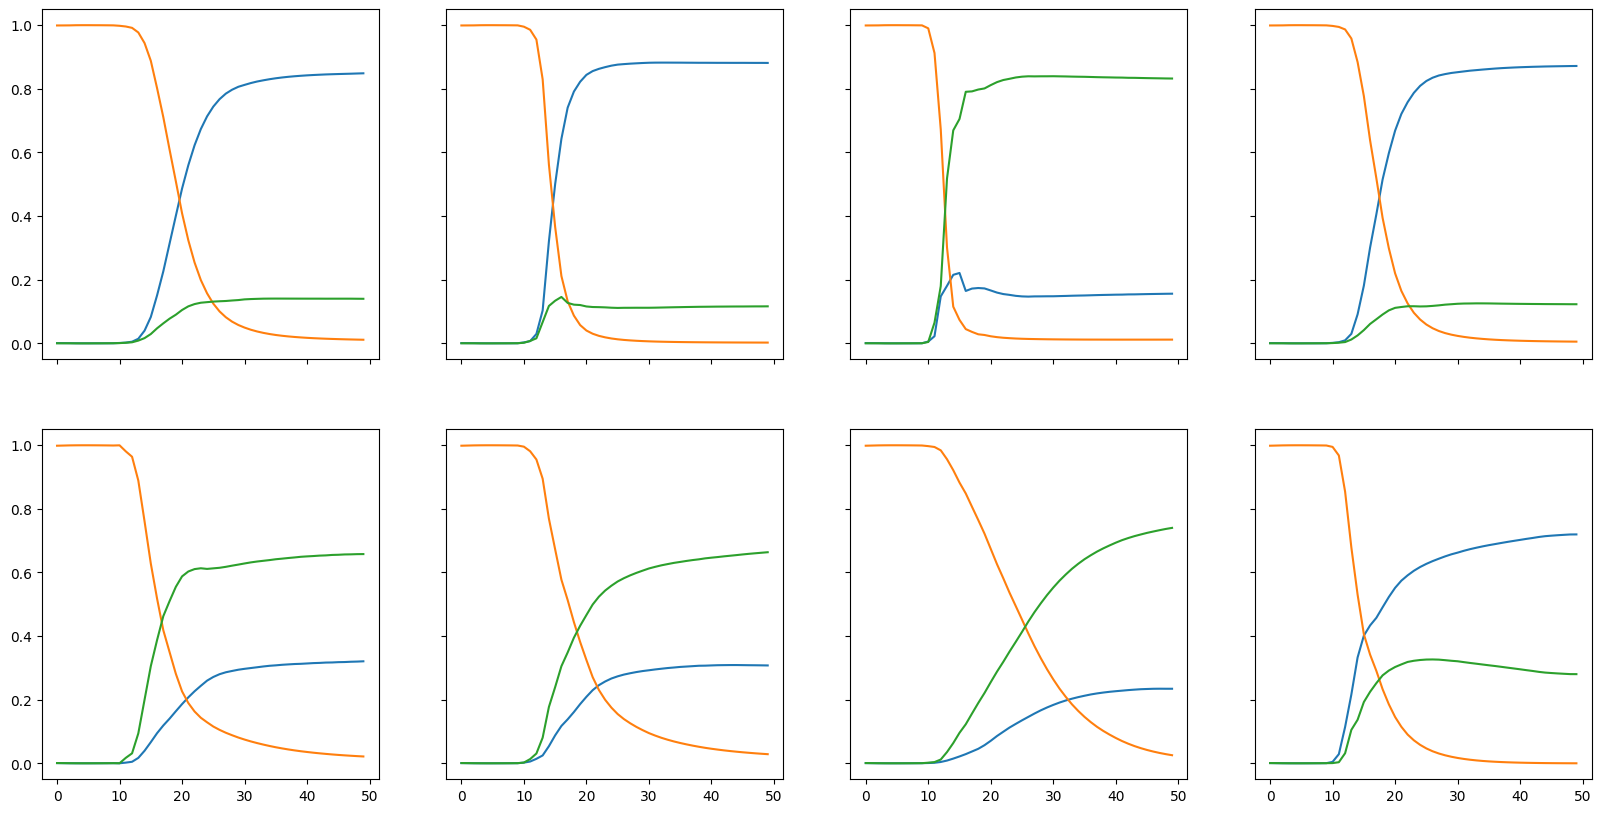

In [132]:
run = main()